---
# Language Modeling with Transformers

In this assignment, you will implement Transformers for language modeling.

As in previous assignments, you will see code blocks that look like this:
```python
###############################################################################
# TODO: Create a variable x with value 536.                                   #
###############################################################################
# Replace "pass" statement with your code
pass
# END OF YOUR CODE
```

You should replace the `pass` statement with your own code and leave the blocks intact, like this:
```python
###############################################################################
# TODO: Create a variable x with value 536.                                   #
###############################################################################
# Replace "pass" statement with your code
x = 536
# END OF YOUR CODE
```

Also, please remember:
- Do not write or modify any code outside of code blocks unless otherwise stated.
- Do not delete any cells from the notebook. You may add new cells to perform scratch work, but delete them before submitting.
- Run all cells before submitting. You will only get credit for code that has been run.
- Submit your notebook as `netid.ipynb`, where `netid` is your actual netid.
- Your submission will be graded with PyTorch 1.7.0 and Python 3.6, which are the default versions in Google Colab.

In [1]:
# You may import additional packages as appropriate
from __future__ import print_function
from __future__ import division

import math
import pickle
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import Counter
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pack_padded_sequence, invert_permutation
from torch.nn.utils import clip_grad_norm_

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
assert torch.cuda.is_available(), 'GPU unavailable'

## Data Preparation

A preprocessed dataset is provided in `data.pickle`. It contains 50K English sentences, each consisting of 5-8 tokens. We will use 40K sentences for training, and the remaining 10K for validation. Please put the file in the same directory as this notebook. In Google Colab, you have the option to upload files.

In [3]:
# Load data
with open('data.pickle', 'rb') as f:
  target_text = pickle.load(f)
print(f'There are {len(target_text)} sentences.')

# Show a random sample
idx = random.randrange(len(target_text))
print('Here is a random sample:')
print(target_text[idx])

# Split sentences into words
target_text = [sentence.split(' ') for sentence in target_text]
MAX_LEN = max([len(sentence) for sentence in target_text])
print(f'The maximum sentence length is {MAX_LEN}.')

There are 50000 sentences.
Here is a random sample:
is there an information counter ?
The maximum sentence length is 8.


In [4]:
class Vocab:
  
  def __init__(self, text, min_freq=5):
    
    # Initialize the vocabulary with special tokens
    self.index2word = {
      0: 'pad',  # padding
      1: 'bos',  # begin of sentence
      2: 'eos',  # end of sentence
      3: 'unk',  # unknown
    }
    self.word2index = {v: k for k, v in self.index2word.items()}
    self.size = 4  # initial vocabulary size
    
    # Only add tokens that appear more than `min_freq` times in the training data
    tokens = [token for sentence in text for token in sentence]
    token_freq = Counter(tokens)
    tokens = [token for token in token_freq if token_freq[token] >= min_freq]
    self._build_vocab(tokens)
  
  
  def _build_vocab(self, tokens):
    
    for token in tokens:
      if token not in self.word2index:
        self.word2index[token] = self.size
        self.index2word[self.size] = token
        self.size += 1
  
  
  def __getitem__(self, tokens):
    
    if not isinstance(tokens, (list, tuple)):
      return self.word2index.get(tokens, self.word2index['unk'])
    else:
      return [self.__getitem__(token) for token in tokens]

In [5]:
def get_data_loader(target_text, batch_size):
  """
  Build vocabulary and prepare data.
  """
  # Use the first 40K sentences as training data, and the rest for validation
  target_vocab = Vocab(target_text[:40000])
  
  # Convert each word to its index in the vocabulary
  target_text = target_vocab[target_text]
  # Add 'bos' and 'eos' tokens
  target_text = [[target_vocab['bos']] + sentence + [target_vocab['eos']]
                 for sentence in target_text]
  # Record the length of each sentence
  target_len = [len(sentence) for sentence in target_text]
  # Pad each sentence to `MAX_LEN` (+2 for 'bos' and 'eos')
  target_text = [sentence + [target_vocab['pad']] * (MAX_LEN + 2 - len(sentence))
                 for sentence in target_text]
  # Convert to PyTorch tensors
  target_text = torch.LongTensor(target_text)  # shape: (num_sentences, MAX_LEN+2)
  target_len = torch.LongTensor(target_len)  # shape: (num_sentences,)
  
  train_set = TensorDataset(
    target_text[:40000], target_len[:40000])
  
  val_set = TensorDataset(
    target_text[40000:], target_len[40000:])
  
  loader_kwargs = {
    'batch_size': batch_size,
    'shuffle': True,
    'num_workers': 4,
    'pin_memory': True,
    'drop_last': True,
  }
  
  train_loader = DataLoader(train_set, **loader_kwargs)
  val_loader = DataLoader(val_set, **loader_kwargs)
  
  return target_vocab, train_loader, val_loader

In [6]:
target_vocab, train_loader, val_loader = get_data_loader(target_text, batch_size=100)
print('vocab size:', target_vocab.size)

vocab size: 2591


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Language Modeling

The goal of language modeling is to learn the conditional distribution of the next word $x_t$ given all the previous words $x_{<t}$:
$$
P(x_t \!\mid\! x_{<t}).
$$
This allows us to compute the log-likelihood of a given sentence $x_{1:T}$ as follows:
$$
\log P(x_{1:T}) = \sum_{t=1}^T \log P(x_t \!\mid\! x_{<t}).
$$
Given a language model, we can also generate new sentences by conditioning on the first $C$ words $x_{1:C}$ of the sentence:
$$
\begin{align*}
x_{C+1} &\sim P(x_{C+1} \!\mid\! x_{1:C}), \\
x_{C+2} &\sim P(x_{C+2} \!\mid\! x_{1:C}, x_{C+1}), \\
&\cdots
\end{align*}
$$
If $C=1$ and $x_1 = \text{'bos'}$, then the model is free to generate any sentence from the distribution it has learned.

## Language Modeling with Transformers

The Transformer uses a stack of blocks to compute an embedding of all the previous words:
$$
e_t = f(x_{<t}).
$$
The next word probability is then computed by a linear projection followed by softmax:
$$
P(x_t \!\mid\! x_{<t}) = \text{softmax}(W e_t).
$$

## Self-Attention in Transformers

A core module in each Transformer block is the multi-head causal self-attention, also known as multi-head masked self-attention. It only attends to positions before or at the current position, as opposed to a regular self-attention that can attend to all positions.

<img src="https://jalammar.github.io/images/gpt2/self-attention-and-masked-self-attention.png" width=600>

The exact form of multi-head self-attention is defined in this [paper](https://arxiv.org/pdf/1706.03762.pdf). Please read it carefully as it also describes many implementation details.

Implement `MultiHeadCausalSelfAttention` below:

In [7]:
class MultiHeadCausalSelfAttention(nn.Module):
  
  def __init__(self, d_model, num_heads, dropout=0.):
    super().__init__()
    
    assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
    self.d_model = d_model
    self.num_heads = num_heads
    
    # This dropout is to be applied to the attention weights
    # immediately after the softmax. It was not mentioned
    # in the paper, but is used in the actual implementation.
    self.dropout = nn.Dropout(dropout)
    
    # The weight matrices of all heads are concatenated together
    self.proj_q = nn.Linear(d_model, d_model, bias=False)
    self.proj_k = nn.Linear(d_model, d_model, bias=False)
    self.proj_v = nn.Linear(d_model, d_model, bias=False)
    
    self.proj_o = nn.Linear(d_model, d_model, bias=False)
  
  
  def forward(self, input):
    """
    Inputs:
    - input: A Tensor of shape (batch_size, seq_len, d_model)
      containing sequences of embeddings.
    
    Returns:
    - output: A Tensor of shape (batch_size, seq_len, d_model)
      containing the updated embeddings.
    """
    #########################################################################
    # TODO:                                                                 #
    # Implement the forward pass. No for loop is allowed.                   #
    # You may not use PyTorch's built-in multi-head attention.              #
    #########################################################################
    # Replace "pass" statement with your code
    bs= input.size(0)
    Wq = self.proj_q(input)
    Wk = self.proj_k(input)
    Wv = self.proj_v(input)
    hd = int(self.d_model/self.num_heads)
    mask = ~torch.triu(input.new_ones((input.size(1),input.size(1)), dtype=torch.bool), diagonal=1)

    Wq = Wq.view(bs, -1, self.num_heads, hd).permute(0, 2, 1, 3)
    Wk = Wk.view(bs, -1, self.num_heads, hd).permute(0, 2, 1, 3)
    Wv = Wv.view(bs, -1, self.num_heads, hd).permute(0, 2, 1, 3)

    e = torch.matmul(Wq, Wk.permute(0, 1, 3, 2)) / math.sqrt(hd)
    if mask is not None:
            e = e.masked_fill(mask == 0, -1e10)
    attention = torch.softmax(e, dim = -1)
    output = torch.matmul(self.dropout(attention), Wv)
    output = output.permute(0, 2, 1, 3).contiguous()
    output = output.view(bs, -1, self.d_model)
    output = self.proj_o(output)                     
    # END OF YOUR CODE
    return output

We will use the following helper functions to check your results:

In [8]:
def max_diff(actual, expected):
  return (actual - expected).abs().max().item()

In [9]:
def check_attention(batch_size, seq_len, d_model, num_heads, dropout):
  
  attn = MultiHeadCausalSelfAttention(d_model, num_heads, dropout)
  input = torch.empty(batch_size, seq_len, d_model).normal_()
  torch.manual_seed(0)
  actual_output = attn(input)
  
  input = input.transpose(0, 1)
  in_proj_weight = torch.cat(
    (attn.proj_q.weight,
     attn.proj_k.weight,
     attn.proj_v.weight), dim=0)
  attn_mask = torch.triu(
    input.new_ones((seq_len, seq_len), dtype=torch.bool),
    diagonal=1)
  torch.manual_seed(0)
  expected_output = F.multi_head_attention_forward(
    input, input, input,
    d_model, num_heads,
    in_proj_weight, None,
    None, None, False, dropout,
    attn.proj_o.weight, None,
    need_weights=False,
    attn_mask=attn_mask)[0].transpose(0, 1)
  
  assert actual_output.shape == expected_output.shape, 'incorrect shape'
  
  diff = max_diff(actual_output, expected_output)
  print('diff = %e' % diff)
  assert diff < 1e-5, 'incorrect output'

In [10]:
check_attention(batch_size=64, seq_len=128, d_model=512, num_heads=1, dropout=0.)

diff = 3.613532e-07


In [11]:
check_attention(batch_size=64, seq_len=128, d_model=512, num_heads=8, dropout=0.)

diff = 1.192093e-07


In [12]:
check_attention(batch_size=64, seq_len=128, d_model=512, num_heads=1, dropout=0.1)

diff = 2.980232e-07


In [13]:
check_attention(batch_size=64, seq_len=128, d_model=512, num_heads=8, dropout=0.1)

diff = 1.490116e-07


## Transformer Blocks

A Transformer block contains the following modules:
1. Multi-head causal self-attention
2. Dropout
3. Residual connection
4. Layer normalization
5. Position-wise feed-forward network (with hidden size `d_ff`)
6. Dropout
7. Residual connection
8. Layer normalization

Please refer to the [paper](https://arxiv.org/pdf/1706.03762.pdf) for more details.

Implement `TransformerBlock` below:

In [14]:
class TransformerBlock(nn.Module):
  
  def __init__(self, d_model, num_heads, d_ff, dropout=0.):
    super().__init__()
    #########################################################################
    # TODO:                                                                 #
    # Set up the Transformer block components.                              #
    #########################################################################
    # Replace "pass" statement with your code
    self.d_model= d_model
    self.num_heads = num_heads
    self.d_ff = d_ff
    self.dropout = nn.Dropout(dropout)
    self.mhcsa = MultiHeadCausalSelfAttention(d_model, num_heads, dropout)
    self.layernorm = nn.LayerNorm(d_model)
    self.psffl = nn.Sequential(
        nn.Linear(d_model, d_ff),
        nn.ReLU(),
        nn.Linear(d_ff, d_model),
        nn.Dropout(dropout),
        nn.LayerNorm(d_model))
    # END OF YOUR CODE
  
  
  def forward(self, input):
    """
    Inputs:
    - input: A Tensor of shape (batch_size, seq_len, d_model)
      containing sequences of embeddings.
    
    Returns:
    - output: A Tensor of shape (batch_size, seq_len, d_model)
      containing the updated embeddings.
    """
    #########################################################################
    # TODO:                                                                 #
    # Implement the forward pass.                                           #
    # You may not use PyTorch's built-in Transformer layers.                #
    #########################################################################
    # Replace "pass" statement with your code
    x = self.mhcsa(input)
    x = self.dropout(input)
    x = x+input
    xl = self.layernorm(x)
    xy = self.psffl(xl)
    xi = self.dropout(xl)
    xi = xi+xy
    output = self.layernorm(xi)
    # END OF YOUR CODE
    return output

## Positional Encoding

Self-attention is permutation invariant, meaning it loses the order information. To make use of the order of the sequence, Transformers add positional encodings to the word embeddings before feeding them to the Transformer blocks:

$$
\begin{align*}
PE_{(pos, 2i)} &= \text{sin}(pos / 10000^{2i/d_{model}}), \\
PE_{(pos, 2i+1)} &= \text{cos}(pos / 10000^{2i/d_{model}}),
\end{align*}
$$
where $pos$ is the position and $i$ is the dimension.

For efficiency, the positional encodings are precomputed for $pos \in [0, \text{max_len})$, and the sentences are assumed to have length no greater than $\text{max_len}$.

Implement `PositionalEncoding` below:

In [15]:
class PositionalEncoding(nn.Module):
  
  def __init__(self, max_len, d_model, dropout=0.):
    super().__init__()
    
    self.dropout = nn.Dropout(dropout)
    
    #########################################################################
    # TODO:                                                                 #
    # Precompute the positional encodings.                                  #
    #########################################################################
    # Replace "pass" statement with your code
    pe = torch.zeros(max_len, d_model)
    pos = torch.arange(0, max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    
    pe[:, 0::2] = torch.sin(pos * div_term)
    pe[:, 1::2] = torch.cos(pos * div_term)

    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)
    
    # END OF YOUR CODE
  
  
  def forward(self, input):
    """
    Inputs:
    - input: A Tensor of shape (batch_size, seq_len, d_model)
      containing sequences of word embeddings.
    
    Returns:
    - output: A Tensor of shape (batch_size, seq_len, d_model)
      containing dropout(word embeddings + positional encodings).
    """
    #########################################################################
    # TODO:                                                                 #
    # Implement the forward pass.                                           #
    #########################################################################
    # Replace "pass" statement with your code
    batch_size, seq_len, d_model = input.size()
    x = input
    x = input + self.pe[:, :seq_len]
    output = self.dropout(x)
    # END OF YOUR CODE
    return output

## Transformer Model

Implement `Transformer` below. The model is trained by minimizing cross-entropy for next word prediction. Please refer to the [paper](https://arxiv.org/pdf/1706.03762.pdf) for more details, especially how the weights are shared between the embedding layer and the pre-softmax linear transformation.

In [16]:
class Transformer(nn.Module):
  
  def __init__(self, num_blocks, vocab_size, max_len, d_model, num_heads, d_ff, dropout=0.):
    super().__init__()
    #########################################################################
    # TODO:                                                                 #
    # Set up the Transformer components.                                    #
    #########################################################################
    # Replace "pass" statement with your code
    self.num_blocks= num_blocks
    self.num_heads= num_heads
    self.token_emb = nn.Embedding(vocab_size, d_model)
    self.pos_encod = PositionalEncoding(max_len, d_model)
    self.Tb = TransformerBlock(d_model, num_heads, d_ff)
    self.linear = nn.Linear(d_model, vocab_size)
    self.softmax = nn.Softmax(dim=-1)
    self.dropout = nn.Dropout(dropout)
  
  
  def forward(self, input_text, input_len):
    """
    Perform next word prediction and compute loss.
    
    Inputs:
    - input_text: A LongTensor of shape (batch_size, seq_len)
      containing a mini-batch of sentences padded to `seq_len`.
      Each token is represented by its index in the vocabulary.
    - input_len: A LongTensor of shape (batch_size,)
      containing the actual length of each sentence (before being padded).
    
    Returns:
    - loss: A PyTorch scalar containing the loss for the mini-batch.
    """
    #########################################################################
    # TODO:                                                                 #
    # Implement the forward pass.                                           #
    # You may not use PyTorch's built-in Transformer layers.                #
    #########################################################################
    # Replace "pass" statement with your code
    tokens = self.token_emb(input_text)
    pos_emb = self.pos_encod(tokens)
    y = self.dropout(pos_emb)
    for _ in range(self.num_blocks):
      tb_out=self.Tb(y)
      y=tb_out
    y = self.linear(y)

    input_len, sorted_indices = torch.sort(input_len, descending=True)
    input_text = input_text.index_select(0, sorted_indices)
    y = y.index_select(0, sorted_indices)
    input_len = input_len.cpu()

    input_text_packed = pack_padded_sequence(
      input_text[:, 1:], input_len - 1,  # notice the shift in `target_text`
      batch_first=True, enforce_sorted=True)
    
    pred_packed = pack_padded_sequence(
      y, input_len - 1,
      batch_first=True, enforce_sorted=True)
    loss = F.cross_entropy(pred_packed.data, input_text_packed.data, ignore_index=0)

    # END OF YOUR CODE
    return loss
  
  
  def predict(self, cond_text, pred_len):
    """
    Perform sentence completion given the first few words in the sentence.
    This is achieved by iteratively predicting the next word for `pred_len` steps,
    where the predicted word at step t is concatenated to the input for step t+1.
    
    Inputs:
    - cond_text: A LongTensor of shape (batch_size, cond_len)
      containing a mini-batch of sentences to be completed.
      Each token is represented by its index in the vocabulary.
    - pred_len: (int) number of prediction steps.
    
    Returns:
    - pred: A LongTensor of shape (batch_size, cond_len + pred_len)
      containing the completed sentences.
      Each token is represented by its index in the vocabulary.
    """
    #########################################################################
    # TODO:                                                                 #
    # Implement sentence completion.                                        #
    #########################################################################
    # Replace "pass" statement with your code
    for _ in range(pred_len):
      tokens = self.token_emb(cond_text)
      pos_emb = self.pos_encod(tokens)
      y = self.dropout(pos_emb)
      for _ in range(self.num_blocks):
        y =self.Tb(y)
      y = self.linear(y)
      y = self.softmax(y)
      m = torch.argmax(y,-1)
      pred_token = m[:,-1:]
      cond_text = torch.cat([cond_text,pred_token], dim=1)
    pred = cond_text
    # END OF YOUR CODE
    return pred

## Evaluation

We will evaluate the model on accuracy of sentence completion. Please know that we choose this evaluation protocol for simplicity. There are better evaluation metrics that you should use in your own projects.

In [17]:
def eval_acc(model, data_loader, num_samples=5):
  
  with torch.no_grad():
    model.eval()
    
    cond_len = 4  # provide the first 4 tokens (including 'bos')
    pred_len = MAX_LEN + 2 - cond_len  # predict the rest
    
    total = 0
    correct = 0
    
    for batch, data in enumerate(data_loader):
      data = [d.cuda() for d in data]
      
      cond_text = data[0][:, :cond_len]
      pred = model.predict(cond_text, pred_len)
      
      if batch < num_samples:  # show some samples
        target_sentence = [target_vocab.index2word[token] for token in data[0][0].tolist()]
        pred_sentence = [target_vocab.index2word[token] for token in pred[0].tolist()]
        
        print(f'=== Sample {batch + 1} ===')
        print('target_sentence:', target_sentence)
        print('pred_sentence:  ', pred_sentence)
      
      target_len, sorted_indices = torch.sort(data[1], descending=True)
      target_text = data[0].index_select(0, sorted_indices)
      pred = pred.index_select(0, sorted_indices)
      target_len = target_len.cpu()
      
      target_text_packed = pack_padded_sequence(
        target_text[:, cond_len:], target_len - cond_len,
        batch_first=True, enforce_sorted=True)
      
      pred_packed = pack_padded_sequence(
        pred[:, cond_len:], target_len - cond_len,
        batch_first=True, enforce_sorted=True)
      
      total += target_text_packed.data.shape[0]
      correct += (pred_packed.data == target_text_packed.data).sum().item()
    
    acc = 100 * correct / total
  
  return acc

## Training

A basic training script is provided below. You need to make modifications as appropriate. Please refer to the [paper](https://arxiv.org/pdf/1706.03762.pdf) for typical hyperparameter values and learning rate schedules.

To get full credit, your model should **achieve at least 38% validation accuracy**.

In [18]:
def train(model, train_loader, val_loader, num_epochs, learning_rate):
  
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  
  loss_history = []
  for epoch in range(num_epochs):
    val_acc = eval_acc(model, val_loader, num_samples=0)
    
    model.train()
    for batch, data in enumerate(train_loader):
      data = [d.cuda() for d in data]
      
      optimizer.zero_grad()
      loss = model(*data)
      loss.backward()
      clip_grad_norm_(model.parameters(), 1)  # gradient clipping
      optimizer.step()
      
      with torch.no_grad():
        loss_history.append(loss.item())
        if batch == 0:
          print('Train Epoch: {:3} \t Loss: {:F} \t Val Acc: {:F}'.format(
            epoch, loss.item(), val_acc))
  
  return model, loss_history

In [22]:
torch.manual_seed(0)

batch_size = 100
num_epochs = 30
learning_rate = 0.0001

num_blocks = 9
d_model = 512
num_heads = 8
d_ff = 4 * d_model
dropout = 0.1

target_vocab, train_loader, val_loader = get_data_loader(target_text, batch_size)
model = Transformer(num_blocks, target_vocab.size, MAX_LEN + 2, d_model, num_heads, d_ff, dropout)
model = model.cuda()

model, loss_history = train(model, train_loader, val_loader, num_epochs, learning_rate)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Epoch:   0 	 Loss: 8.217893 	 Val Acc: 0.044283
Train Epoch:   1 	 Loss: 3.412091 	 Val Acc: 23.567443
Train Epoch:   2 	 Loss: 3.285695 	 Val Acc: 22.748207
Train Epoch:   3 	 Loss: 3.331706 	 Val Acc: 23.494376
Train Epoch:   4 	 Loss: 3.112067 	 Val Acc: 23.700292
Train Epoch:   5 	 Loss: 3.218395 	 Val Acc: 23.675937
Train Epoch:   6 	 Loss: 2.975890 	 Val Acc: 23.295102
Train Epoch:   7 	 Loss: 3.070854 	 Val Acc: 23.534231
Train Epoch:   8 	 Loss: 3.006568 	 Val Acc: 23.399167
Train Epoch:   9 	 Loss: 3.013700 	 Val Acc: 24.484102
Train Epoch:  10 	 Loss: 2.938579 	 Val Acc: 23.374812
Train Epoch:  11 	 Loss: 2.952747 	 Val Acc: 22.380657
Train Epoch:  12 	 Loss: 2.936075 	 Val Acc: 23.731290
Train Epoch:  13 	 Loss: 2.905391 	 Val Acc: 24.098840
Train Epoch:  14 	 Loss: 2.876745 	 Val Acc: 24.284829
Train Epoch:  15 	 Loss: 2.809169 	 Val Acc: 23.950492
Train Epoch:  16 	 Loss: 2.880395 	 Val Acc: 23.144540
Train Epoch:  17 	 Loss: 2.756679 	 Val Acc: 23.337171
Train Epoch

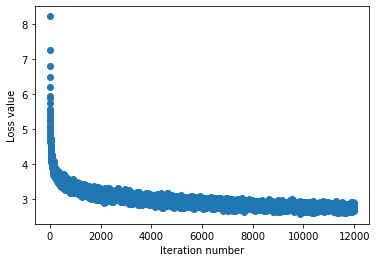

In [23]:
plt.plot(loss_history, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [24]:
train_acc = eval_acc(model, train_loader)
print('Training Accuracy:', train_acc)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


=== Sample 1 ===
target_sentence: ['bos', 'she', 'presented', 'him', 'with', 'the', 'unk', '.', 'eos', 'pad']
pred_sentence:   ['bos', 'she', 'presented', 'him', 'to', 'the', 'unk', '.', 'eos', '.']
=== Sample 2 ===
target_sentence: ['bos', 'the', 'heater', 'doesn', 't', 'work', '.', 'eos', 'pad', 'pad']
pred_sentence:   ['bos', 'the', 'heater', 'doesn', 't', 'believe', 'you', '.', 'eos', '.']
=== Sample 3 ===
target_sentence: ['bos', 'this', 'room', 'is', 'not', 'very', 'large', '.', 'eos', 'pad']
pred_sentence:   ['bos', 'this', 'room', 'is', 'unk', '.', 'eos', '.', 'eos', '.']
=== Sample 4 ===
target_sentence: ['bos', 'i', 'took', 'part', 'in', 'the', 'unk', '.', 'eos', 'pad']
pred_sentence:   ['bos', 'i', 'took', 'part', 'in', 'the', 'unk', '.', 'eos', '.']
=== Sample 5 ===
target_sentence: ['bos', 'he', 's', 'acting', 'on', 'his', 'own', '.', 'eos', 'pad']
pred_sentence:   ['bos', 'he', 's', 'acting', 'up', '.', 'eos', '.', 'eos', '.']
Training Accuracy: 24.590582424595578


In [26]:
val_acc = eval_acc(model, val_loader)
print('Validation Accuracy:', val_acc)
assert val_acc >= 38

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


=== Sample 1 ===
target_sentence: ['bos', 'i', 'm', 'being', 'unk', '.', 'eos', 'pad', 'pad', 'pad']
pred_sentence:   ['bos', 'i', 'm', 'being', 'unk', '.', 'eos', '.', 'eos', '.']
=== Sample 2 ===
target_sentence: ['bos', 'he', 'has', 'already', 'said', 'yes', '.', 'eos', 'pad', 'pad']
pred_sentence:   ['bos', 'he', 'has', 'already', 'unk', '.', 'eos', '.', 'eos', '.']
=== Sample 3 ===
target_sentence: ['bos', 'germany', 'was', 'once', 'unk', 'with', 'italy', '.', 'eos', 'pad']
pred_sentence:   ['bos', 'germany', 'was', 'once', 'a', 'unk', '.', 'eos', '.', 'eos']
=== Sample 4 ===
target_sentence: ['bos', 'this', 'is', 'a', 'little', 'gift', 'for', 'you', '.', 'eos']
pred_sentence:   ['bos', 'this', 'is', 'a', 'unk', '.', 'eos', '.', 'eos', '.']
=== Sample 5 ===
target_sentence: ['bos', 'would', 'you', 'mind', 'if', 'i', 'smoke', '?', 'eos', 'pad']
pred_sentence:   ['bos', 'would', 'you', 'mind', 'if', 'i', 'm', 'busy', '.', 'eos']
Validation Accuracy: 23.45894960588079


AssertionError: ignored